# Alternative methods: Laplace Transform and sobel, direcitonal derivatives maps, and line-profile peak search.

Author: Dan Shaked-Renous<br><br>

The Laplace Transform and Sobel work was based on work started by Sarah Shannon.<br>
Part of the code of the directional derivative maps was inspired by the reository at https://github.com/cynicphoenix/Canny-Edge-Detector .  

In [200]:
import os
from os import listdir
from os.path import isfile, join
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray, rgb2hsv
import statistics
from skimage import filters as flt
from skimage.segmentation import watershed
from skimage.filters import sobel
from scipy import ndimage as ndi


from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [201]:
# Add /scr/data folder to your system path
sys.path.append(os.pardir + '/src/data')

import segment_image as si
from segment_image import is_RGB

In [202]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
from skimage.color import rgb2gray, rgb2hsv
from skimage import io, color, filters, segmentation, exposure, morphology, util
from skimage.segmentation import watershed
from skimage.filters import sobel, roberts, laplace
from scipy import ndimage as ndi
from skimage import filters as flt 
from skimage.segmentation import flood, flood_fill
import cv2 

In [203]:
fname = '../data/interim/merged_data/not_measured/1M-A31N_10x.jpg' #9L-59_10x.jpg'
image = io.imread(fname)

In [204]:
gray = rgb2gray(image[:1700])

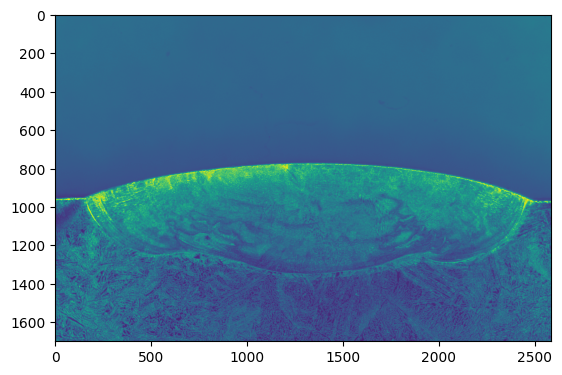

In [205]:
plt.imshow(gray)

# Applying the laplace+sobel algorithm

In [206]:
fname = '../data/interim/merged_data/not_measured/1M-A31N_10x.jpg'

img_large   = cv2.imread(fname)

In [207]:
# take the cropping values from crop_image function

img = img_large[:1700]

4


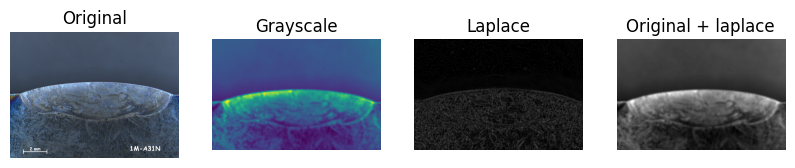

In [208]:
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_grayscale = cv2.GaussianBlur(img_grayscale, (71, 71), 0)

#step 1
edge_laplace = cv2.Laplacian(img_grayscale, -1, ksize=1, scale=1,delta=0,borderType=cv2.BORDER_DEFAULT)

#step 2 add original image and laplace
new_image = img_grayscale + edge_laplace

print(np.max(edge_laplace))
fig, axes = plt.subplots(ncols=4, nrows = 1, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(img_large)
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(img_grayscale)
ax[1].set_title('Grayscale')
ax[1].set_axis_off()

ax[2].imshow(edge_laplace,cmap=plt.cm.gray)
ax[2].set_title('Laplace')
ax[2].set_axis_off()

ax[3].imshow(new_image,cmap=plt.cm.gray)
ax[3].set_title('Original + laplace')
ax[3].set_axis_off()

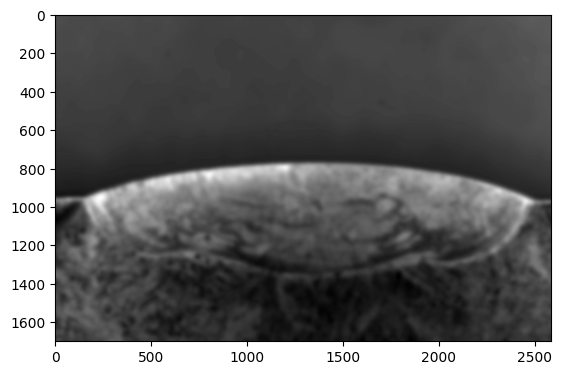

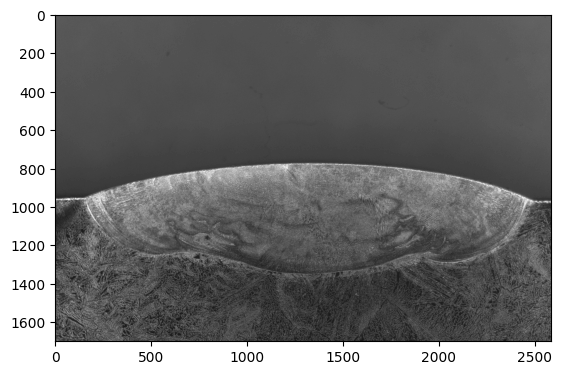

In [209]:
plt.imshow(new_image, cmap=plt.cm.gray)
plt.show()
plt.imshow(rgb2gray(img), cmap=plt.cm.gray)

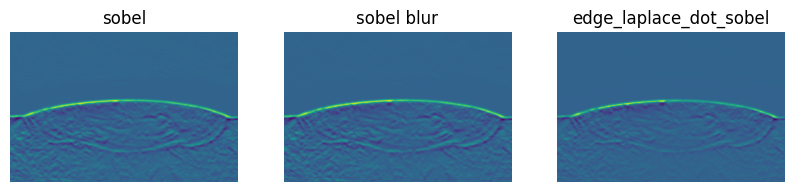

In [210]:
#step 3 sobel gradient on original image
sobel=cv2.Sobel(img_grayscale, cv2.CV_64F, 0, 1, ksize=5)

#step 4 mean blur
mean_blur = cv2.blur(sobel, (5, 5))

#step 5
new_image_dot_mean_blur = cv2.multiply(new_image, mean_blur,dtype=cv2.CV_64F)

fig, axes = plt.subplots(ncols=3, nrows = 1, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(sobel)
ax[0].set_title('sobel')
ax[0].set_axis_off()

ax[1].imshow(mean_blur)
ax[1].set_title('sobel blur')
ax[1].set_axis_off()

ax[2].imshow(new_image_dot_mean_blur)
ax[2].set_title('edge_laplace_dot_sobel')
ax[2].set_axis_off()

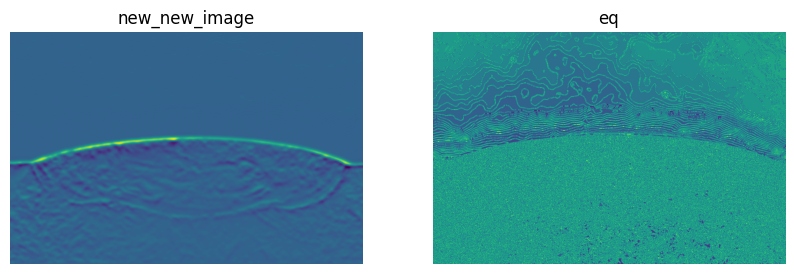

In [211]:
#step 6
new_new_image = img_grayscale + new_image_dot_mean_blur

#step 7
new_new_image_u8 = np.uint8(new_new_image)

equ = cv2.equalizeHist(new_new_image_u8)

fig, axes = plt.subplots(ncols=2, nrows = 1, figsize=(10, 5))
ax = axes.ravel()


ax[0].imshow(new_new_image)
ax[0].set_title('new_new_image')
ax[0].set_axis_off()

ax[1].imshow(equ)
ax[1].set_title('eq')
ax[1].set_axis_off()

Continuing investigating with `new_new_image`.

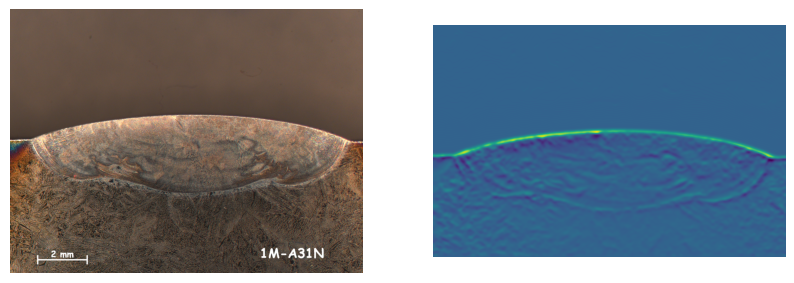

In [245]:
fig, axes = plt.subplots(ncols=2, nrows = 1, figsize=(10, 5))
ax = axes.ravel()


ax[0].imshow(image)
ax[0].set_axis_off()

ax[1].imshow(new_new_image)
ax[1].set_axis_off()

In [212]:
from skimage.util import img_as_float
from eda_helper import sideBside

looking at the line profiles

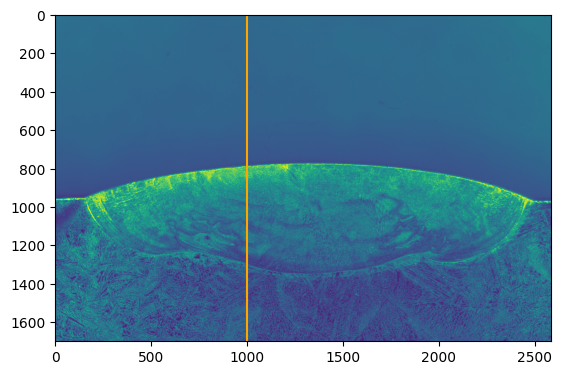

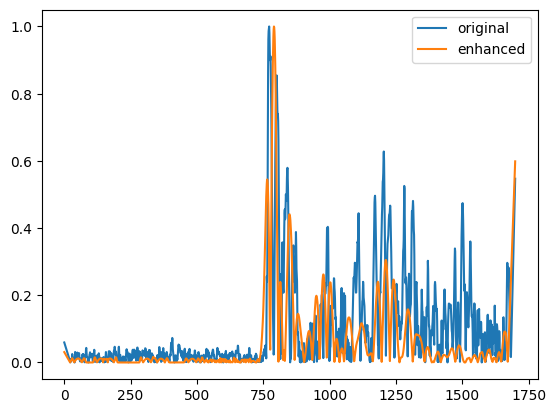

In [213]:
xline = 1000
plt.imshow(gray)
plt.axvline(xline,color='orange')
plt.show()

sav_2d_gray = savgol_filter(gray[:,xline], 51, 3, deriv=2) 
sav_2d_abs_gray = abs(sav_2d_gray)

sav_2d_nni = savgol_filter(img_as_float(new_new_image)[:,xline], 51, 3, deriv=2) 
sav_2d_abs_nni = abs(sav_2d_nni)

plt.plot(sav_2d_abs_gray.dot(1/sav_2d_abs_gray.max()), label='original')
plt.plot(sav_2d_abs_nni.dot(1/sav_2d_abs_nni.max()), label='enhanced')
plt.legend()
plt.show()

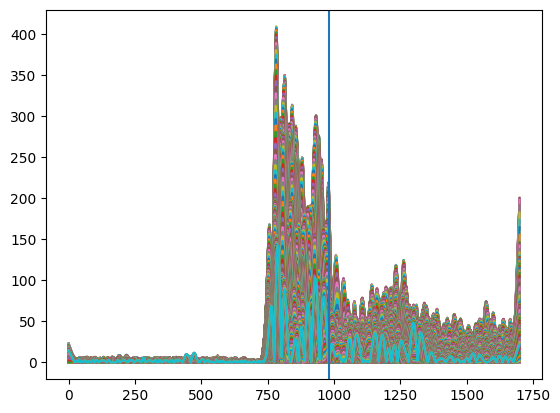

In [214]:
for xline in range(gray.shape[0]):
    sav_2d_nni = savgol_filter(img_as_float(new_new_image)[:,xline], 51, 3, deriv=2) 
    sav_2d_abs_nni = abs(sav_2d_nni)
    
    plt.plot(sav_2d_abs_nni, label='enhanced')
    
plt.axvline(980)
plt.show()

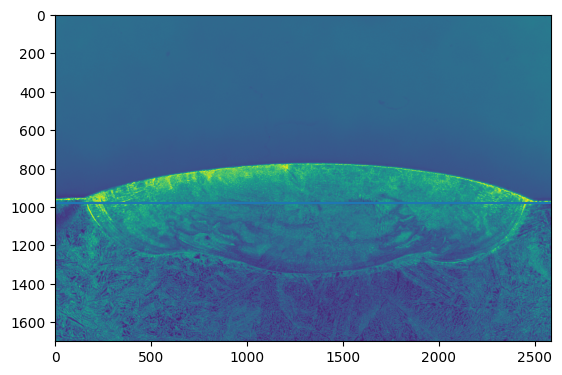

In [215]:
plt.imshow(gray)
plt.axhline(980)

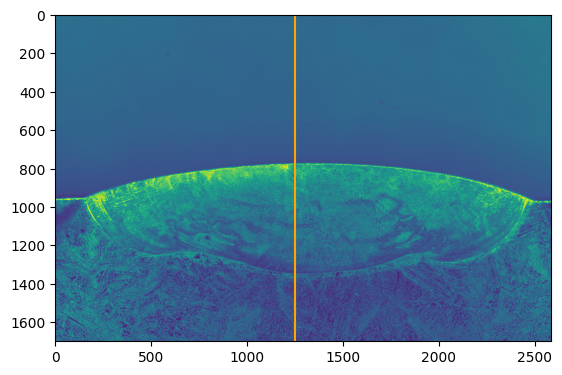

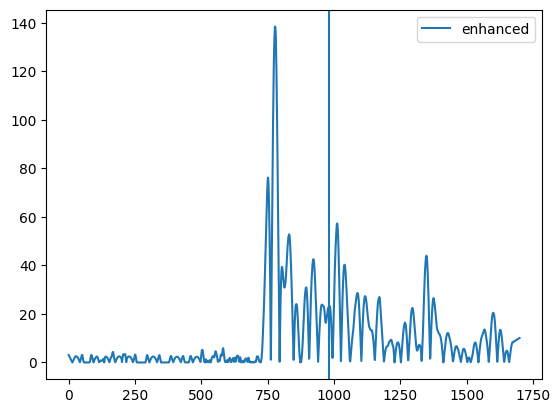

In [216]:
xline = 1250
plt.imshow(gray)
plt.axvline(xline,color='orange')
plt.show()

sav_2d_gray = savgol_filter(gray[:,xline], 51, 3, deriv=2) 
sav_2d_abs_gray = abs(sav_2d_gray)

sav_2d_nni = savgol_filter(img_as_float(new_new_image)[:,xline], 51, 3, deriv=2) 
sav_2d_abs_nni = abs(sav_2d_nni)

# plt.plot(sav_2d_abs_gray.dot(1/sav_2d_abs_gray.max()), label='original')
plt.plot(sav_2d_abs_nni, label='enhanced')
plt.legend()
plt.axvline(980)
plt.show()

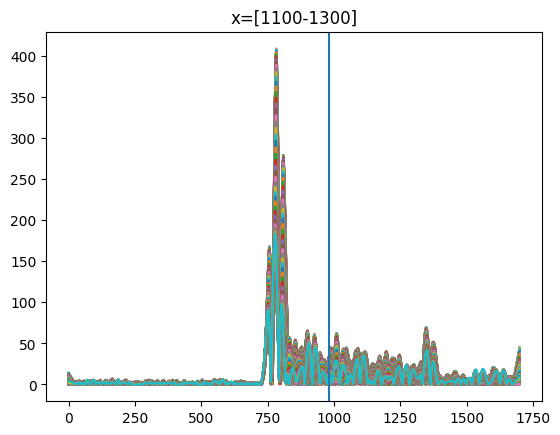

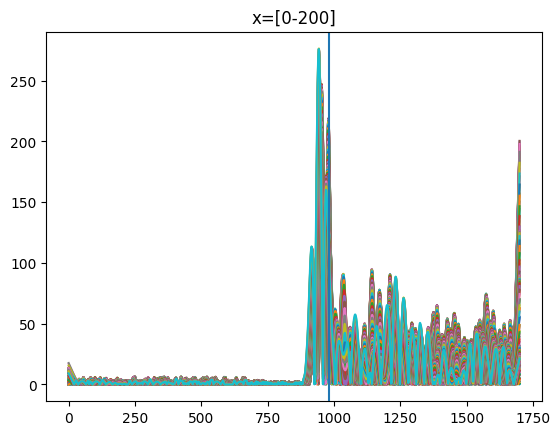

In [217]:
for xline in range(1100,1300):
    sav_2d_nni = savgol_filter(img_as_float(new_new_image)[:,xline], 51, 3, deriv=2) 
    sav_2d_abs_nni = abs(sav_2d_nni)
    
    plt.plot(sav_2d_abs_nni, label='enhanced')
    
plt.axvline(980)
plt.title('x=[1100-1300]')
plt.show()

for xline in range(200):
    sav_2d_nni = savgol_filter(img_as_float(new_new_image)[:,xline], 51, 3, deriv=2) 
    sav_2d_abs_nni = abs(sav_2d_nni)
    
    plt.plot(sav_2d_abs_nni, label='enhanced')
    
plt.title('x=[0-200]')
plt.axvline(980)
plt.show()

There's some continuity. between the peaks but it is hard to find it automatically. <br>
Tring to plot the 2nd derivative of the savgol smoothing function of the line profiles in x and y direction.

In [218]:
savgol_img_x = []
for xline in range(new_new_image.shape[1]):
    sav_2d_nni = savgol_filter(img_as_float(new_new_image)[:,xline], 51, 3, deriv=2) 
    sav_2d_abs_nni = abs(sav_2d_nni)
    savgol_img_x.append(sav_2d_nni)
    
savgol_img_y = []
for yline in range(new_new_image.shape[0]):
    sav_2d_nni = savgol_filter(img_as_float(new_new_image)[yline], 51, 3, deriv=2) 
    sav_2d_abs_nni = abs(sav_2d_nni)
    savgol_img_y.append(sav_2d_nni)
    


`img_2nd_diff` maps the magnitude of the x and y 2nd derivative

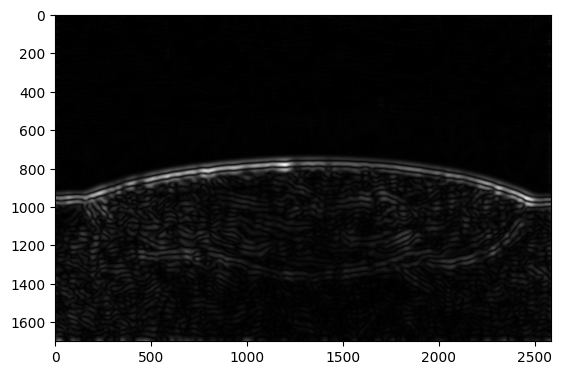

In [219]:
x_2nd_diff = img_as_float(np.array(savgol_img_x).transpose())
y_2nd_diff = img_as_float(np.array(savgol_img_y)) 
img_2nd_diff = np.hypot(x_2nd_diff,y_2nd_diff)             
plt.imshow(img_2nd_diff, cmap = plt.get_cmap('gray'))
plt.show()

Trying to enhance the edges by imltiplting the above image with the new_new_image

In [220]:
gauss_2nd_diff_less0p5 = flt.gaussian(img_2nd_diff.dot(1/img_2nd_diff.max()) >.05, sigma=11)

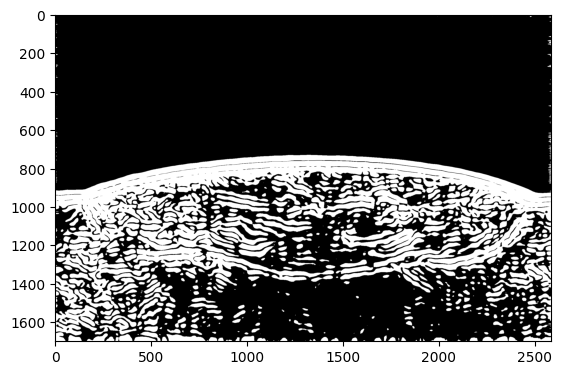

In [221]:
less0p4_2nd_diff = img_2nd_diff.dot(1/img_2nd_diff.max()) >.04
plt.imshow(less0p4_2nd_diff, cmap = plt.get_cmap('gray'))
plt.show()

In [222]:
from skimage import morphology
b = morphology.remove_small_objects(less0p4_2nd_diff, 4000)

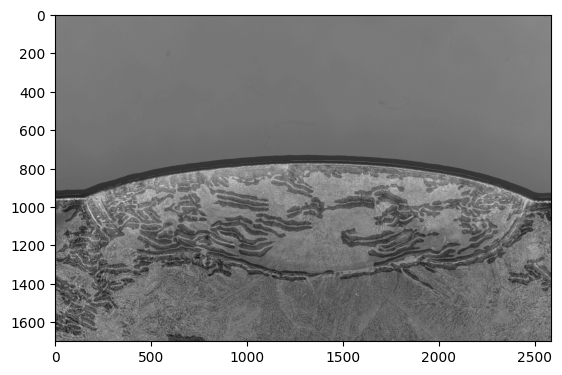

In [223]:
plt.imshow(gray, cmap = plt.get_cmap('gray'))

plt.imshow(b*-1, cmap = plt.get_cmap('gray'), alpha=0.2)

plt.show()

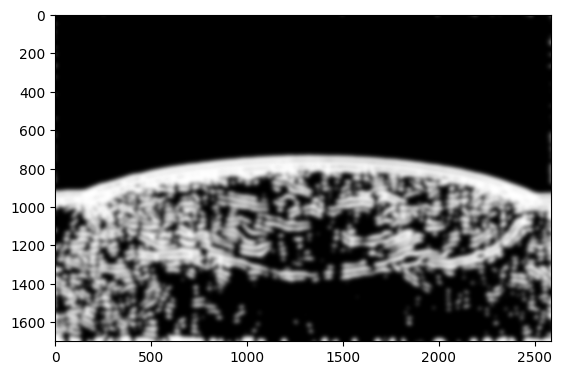

In [224]:
plt.imshow(gauss_2nd_diff_less0p5, cmap = plt.get_cmap('gray'))
plt.show()

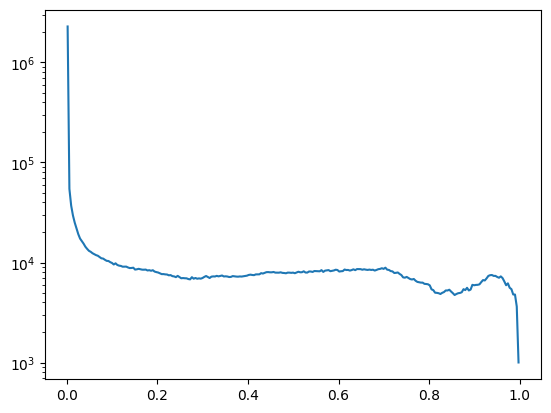

In [225]:
from skimage.exposure import histogram

hist = histogram(gauss_2nd_diff_less0p5, nbins=255)
plt.plot(hist[1], hist[0])
plt.yscale('log')

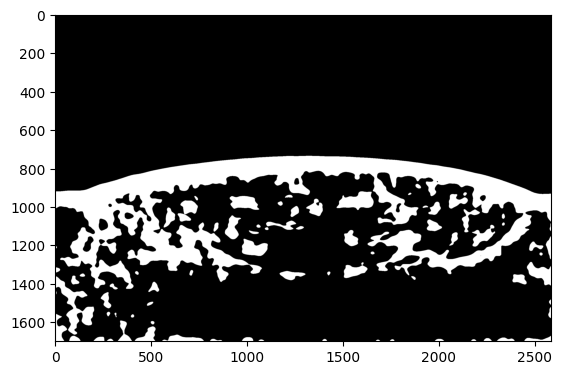

In [226]:
plt.imshow(morphology.remove_small_objects(gauss_2nd_diff_less0p5>.6, 100), cmap = plt.get_cmap('gray'))
plt.show()

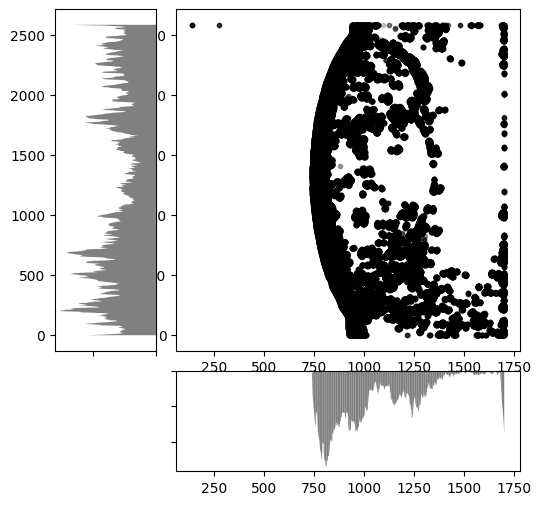

In [227]:
x, y = np.where(img_2nd_diff/img_2nd_diff.max() > 0.1)

# Set up the axes with gridspec
fig = plt.figure(figsize=(6, 6))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# scatter points on the main axes
main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)

# histogram on the attached axes
x_hist.hist(x, img_2nd_diff.shape[0], histtype='stepfilled',
            orientation='vertical', color='gray')
x_hist.invert_yaxis()

y_hist.hist(y, img_2nd_diff.shape[1], histtype='stepfilled',
            orientation='horizontal', color='gray')
y_hist.invert_xaxis()

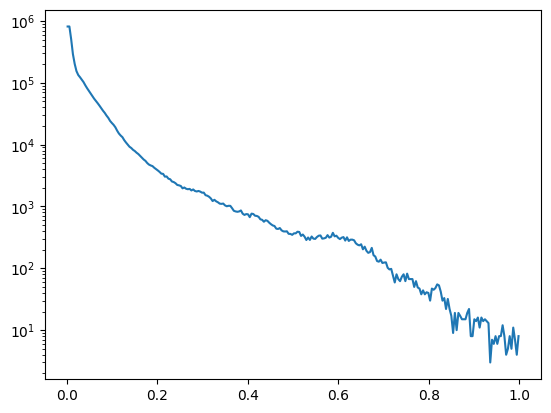

In [228]:
hist, hist_centers = histogram(img_2nd_diff/img_2nd_diff.max(), nbins=256)
plt.plot(hist_centers, hist, label='original')
plt.yscale('log')

# Tests with first derivative

In [229]:
savgol_img_x1 = []
for xline in range(new_new_image.shape[1]):
    sav_1d_nni = savgol_filter(img_as_float(new_new_image)[:,xline], 51, 3, deriv=1) 
    sav_1d_abs_nni = abs(sav_1d_nni)
    savgol_img_x1.append(sav_1d_nni)
    
savgol_img_y1 = []
for yline in range(new_new_image.shape[0]):
    sav_1d_nni = savgol_filter(img_as_float(new_new_image)[yline], 51, 3, deriv=1) 
    sav_1d_abs_nni = abs(sav_1d_nni)
    savgol_img_y1.append(sav_1d_nni)
    


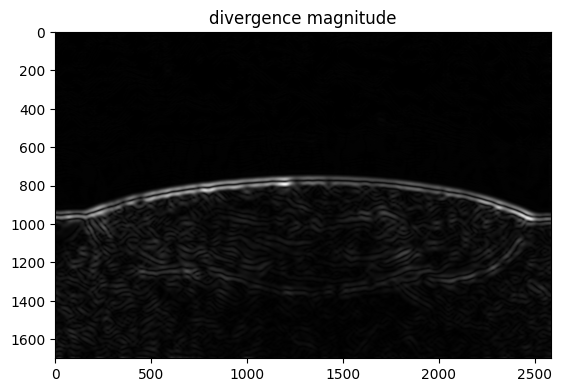

In [230]:
x_1st_diff = img_as_float(np.array(savgol_img_x1).transpose())
y_1st_diff = img_as_float(np.array(savgol_img_y1)) 
img_1st_diff = np.hypot(x_1st_diff,y_1st_diff)             
plt.imshow(img_1st_diff, cmap = plt.get_cmap('gray'))
plt.title('divergence magnitude')
plt.show()

Trying to enhance the edges by imltiplting the above image with the new_new_image

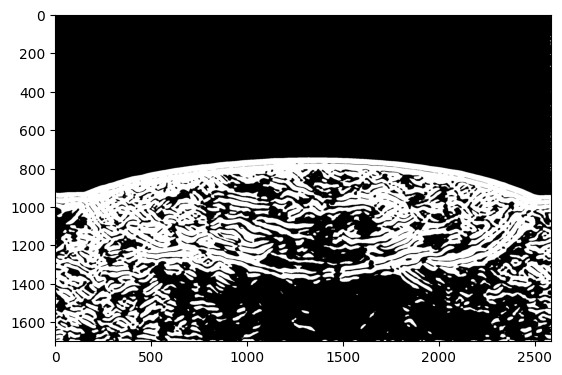

In [231]:
less0p4_1st_diff = img_1st_diff.dot(1/img_1st_diff.max()) >.04
plt.imshow(less0p4_1st_diff, cmap = plt.get_cmap('gray'))
plt.show()

In [232]:
from skimage import morphology
b = morphology.remove_small_objects(less0p4_1st_diff, 30000)

In [233]:
c = morphology.skeletonize(less0p4_1st_diff)


In [234]:
bc = morphology.remove_small_objects(c, 10)

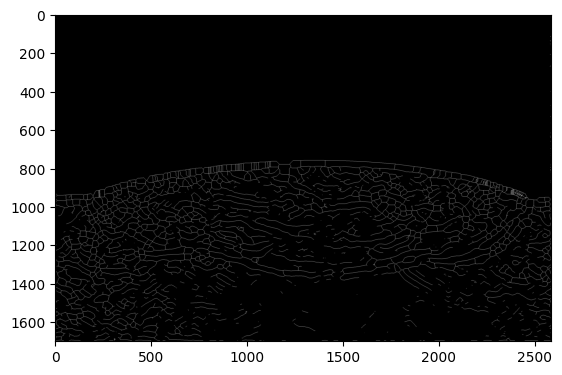

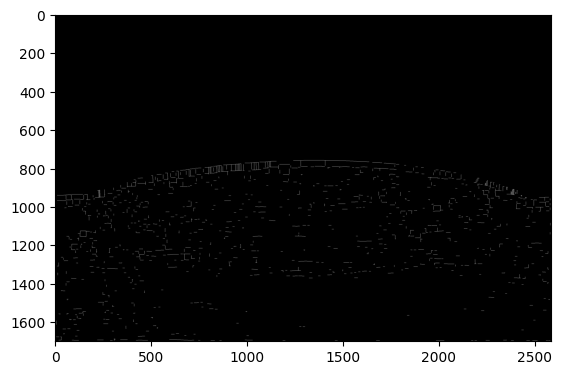

In [235]:
plt.imshow(c, cmap = plt.get_cmap('gray'))
plt.show()
plt.imshow(bc, cmap = plt.get_cmap('gray'))
plt.show()


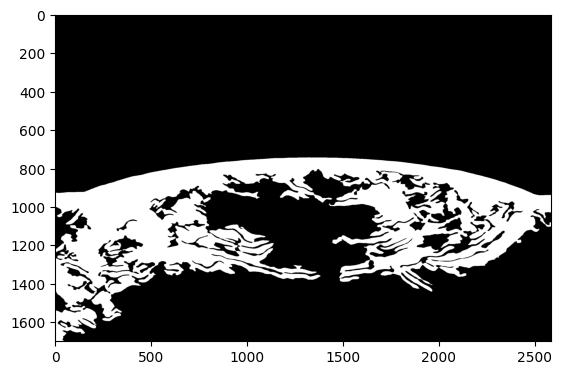

In [236]:

plt.imshow(morphology.remove_small_holes(b, 1000), cmap = plt.get_cmap('gray'))

In [237]:
less0p4_1st_diff.ravel()

array([False, False, False, ...,  True,  True,  True])

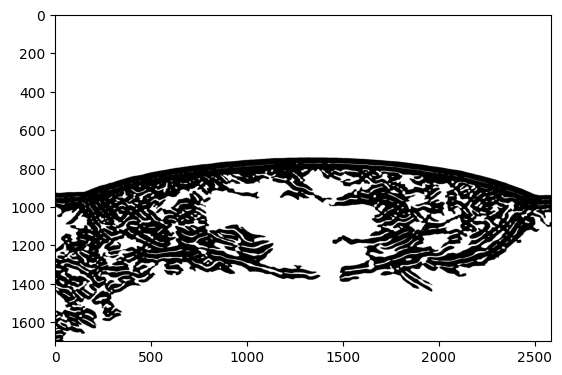

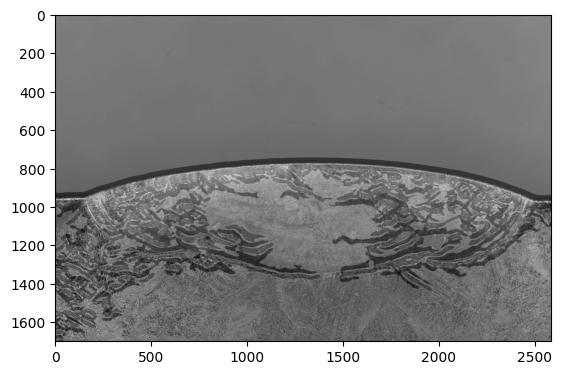

In [238]:
plt.imshow(b*-1, cmap = plt.get_cmap('gray'))

plt.show()
plt.imshow(gray, cmap = plt.get_cmap('gray'))

plt.imshow(b*-1, cmap = plt.get_cmap('gray'), alpha=0.2)

plt.show()

# Testing full implementation of the canny edge

In [239]:
#Function to include weak pixels that are connected to chain of strong pixels 
def DFS(img) :
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            if(img[i, j] == 1) :
                t_max = max(img[i-1, j-1], img[i-1, j], img[i-1, j+1], img[i, j-1],
                            img[i, j+1], img[i+1, j-1], img[i+1, j], img[i+1, j+1])
                if(t_max == 2) :
                    img[i, j] = 2
                
                    
#Hysteresis Thresholding
def hysteresis_thresholding(img) :
    low_ratio = 0.10
    high_ratio = 0.30
    diff = np.max(img) - np.min(img)
    t_low = np.min(img) + low_ratio * diff
    t_high = np.min(img) + high_ratio * diff
    
    temp_img = np.copy(img)
    
    #Assign values to pixels
    for i in range(1, int(img.shape[0] - 1)) :
        for j in range(1, int(img.shape[1] - 1)) :
            #Strong pixels
            if(img[i, j] > t_high) :
                temp_img[i, j] = 2
            #Weak pixels
            elif(img[i, j] < t_low) :
                temp_img[i, j] = 0
            #Intermediate pixels
            else :
                temp_img[i, j] = 1
    
    #Include weak pixels that are connected to chain of strong pixels 
    total_strong = np.sum(temp_img == 2)
    while(1) :
        DFS(temp_img)
        if(total_strong == np.sum(temp_img == 2)) :
            break
        total_strong = np.sum(temp_img == 2)
    
    #Remove weak pixels
    for i in range(1, int(temp_img.shape[0] - 1)) :
        for j in range(1, int(temp_img.shape[1] - 1)) :
            if(temp_img[i, j] == 1) :
                temp_img[i, j] = 0
    
    temp_img = temp_img/np.max(temp_img)
    return temp_img    

In [240]:
# Find the closest direciton
def closest_dir_function(grad_dir) :
    closest_dir_arr = np.zeros(grad_dir.shape)
    for i in range(1, int(grad_dir.shape[0] - 1)) :
        for j in range(1, int(grad_dir.shape[1] - 1)) :
            
            if((grad_dir[i, j] > -22.5 and grad_dir[i, j] <= 22.5) or (grad_dir[i, j] <= -157.5 and grad_dir[i, j] > 157.5)) :
                closest_dir_arr[i, j] = 0
                
            elif((grad_dir[i, j] > 22.5 and grad_dir[i, j] <= 67.5) or (grad_dir[i, j] <= -112.5 and grad_dir[i, j] > -157.5)) :
                closest_dir_arr[i, j] = 45
                
            elif((grad_dir[i, j] > 67.5 and grad_dir[i, j] <= 112.5) or (grad_dir[i, j] <= -67.5 and grad_dir[i, j] > -112.5)) : 
                closest_dir_arr[i, j] = 90
                
            else:
                closest_dir_arr[i, j] = 135
         
    return closest_dir_arr


#2.b : Convert to thinned edge
def non_maximal_suppressor(grad_mag, closest_dir) :
    thinned_output = np.zeros(grad_mag.shape)
    for i in range(1, int(grad_mag.shape[0] - 1)) :
        for j in range(1, int(grad_mag.shape[1] - 1)) :
            
            if(closest_dir[i, j] == 0) :
                if((grad_mag[i, j] > grad_mag[i, j+1]) and (grad_mag[i, j] > grad_mag[i, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 45) :
                if((grad_mag[i, j] > grad_mag[i+1, j+1]) and (grad_mag[i, j] > grad_mag[i-1, j-1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            elif(closest_dir[i, j] == 90) :
                if((grad_mag[i, j] > grad_mag[i+1, j]) and (grad_mag[i, j] > grad_mag[i-1, j])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
            else :
                if((grad_mag[i, j] > grad_mag[i+1, j-1]) and (grad_mag[i, j] > grad_mag[i-1, j+1])) :
                    thinned_output[i, j] = grad_mag[i, j]
                else :
                    thinned_output[i, j] = 0
            
    return thinned_output/np.max(thinned_output) 

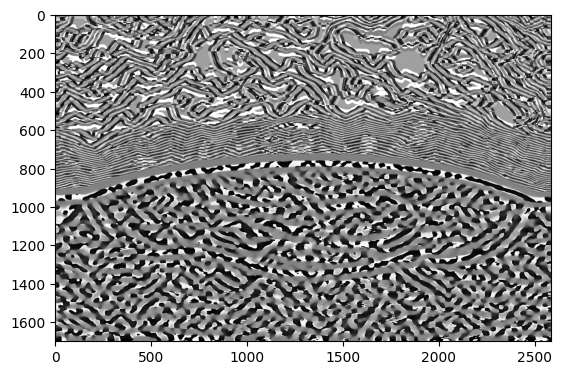

In [241]:
#Compute direction of gradient
grad_dir = np.degrees(np.arctan2(y_2nd_diff, x_2nd_diff))
plt.imshow(grad_dir, cmap = plt.get_cmap('gray'))
plt.show()

## Short sagway: testing thresholding `grad_dir`

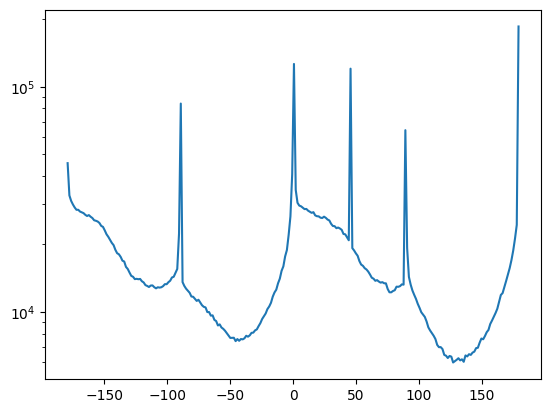

In [100]:
hist, hist_centers = histogram(grad_dir, nbins=256)
plt.plot(hist_centers, hist, label='original')
plt.yscale('log')

In [122]:
find_peaks(hist, prominence=300)

(array([ 64, 128, 145, 160, 191]),
 {'prominences': array([ 71402., 118704.,    361.,  99391.,  51862.]),
  'left_bases': array([ 50,  95, 144, 159, 183]),
  'right_bases': array([ 95, 218, 159, 218, 218])})

In [126]:
hist_centers[218]


127.265625

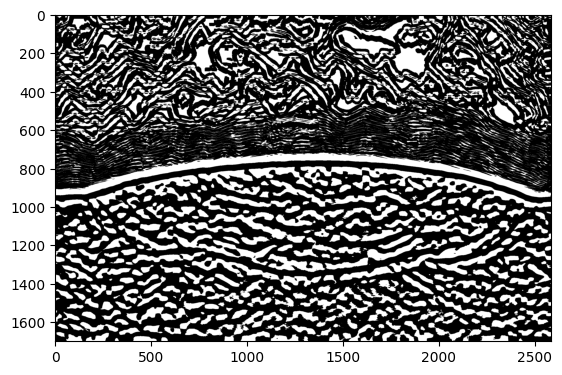

In [147]:
plt.imshow((grad_dir > hist_centers[115]) & (grad_dir < hist_centers[170]), cmap=plt.cm.gray)

In [155]:
dir_threshold = (grad_dir > hist_centers[95]) & (grad_dir < hist_centers[170])

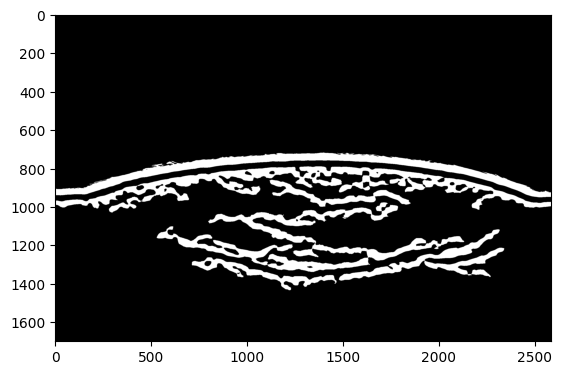

In [161]:
plt.imshow(morphology.remove_small_objects(dir_threshold, 20000), cmap = plt.get_cmap('gray'))

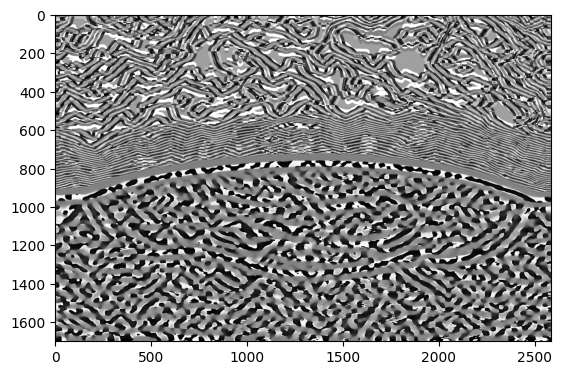

In [131]:
#Compute direction of gradient
grad_dir_1 = np.degrees(np.arctan2(y_1st_diff, x_1st_diff))
plt.imshow(grad_dir, cmap = plt.get_cmap('gray'))
plt.show()

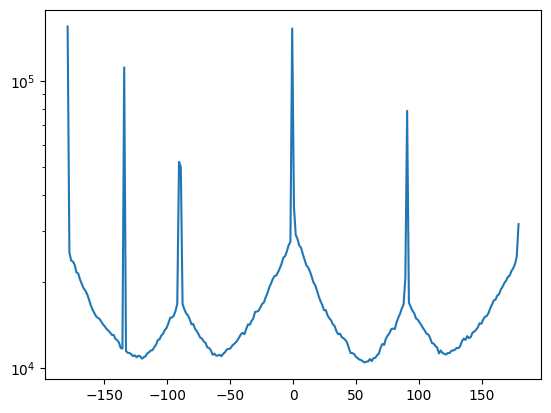

In [132]:
hist, hist_centers = histogram(grad_dir_1, nbins=256)
plt.plot(hist_centers, hist, label='original')
plt.yscale('log')

In [137]:
find_peaks(hist, prominence=200)

(array([ 32,  63, 127, 192, 211, 226]),
 {'prominences': array([ 99725.,  41235., 141389.,  67475.,    273.,    202.]),
  'left_bases': array([ 31,  42,  42, 168, 210, 214]),
  'right_bases': array([ 42,  87, 168, 214, 214, 227])})

In [138]:
hist_centers[211]


117.421875

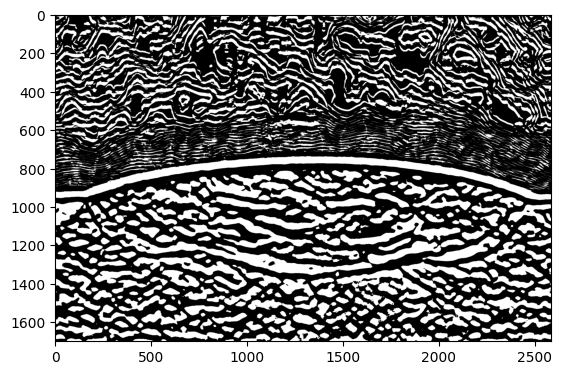

In [142]:
plt.imshow((grad_dir_1 > hist_centers[82]) & (grad_dir_1 < hist_centers[168]), cmap=plt.cm.gray)

In [ ]:
dir_threshold = (grad_dir > hist_centers[95]) & (grad_dir < hist_centers[218])

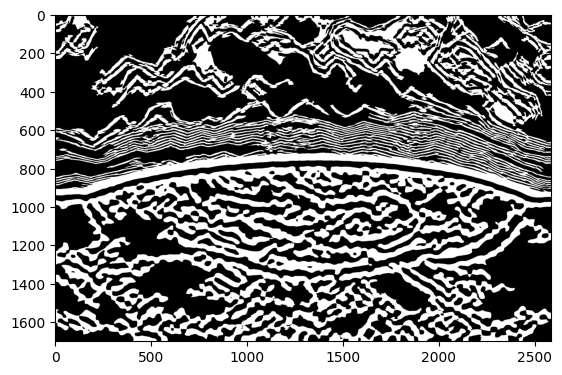

In [ ]:
plt.imshow(morphology.remove_small_objects(dir_threshold, 15000), cmap = plt.get_cmap('gray'))

## End of sagway

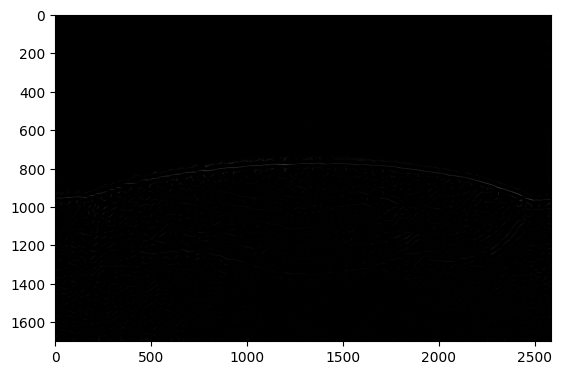

In [94]:
#Phase 2 : Non maximal suppression
closest_dir = closest_dir_function(grad_dir)
thinned_output = non_maximal_suppressor(img_2nd_diff, closest_dir)
plt.imshow(thinned_output, cmap = plt.get_cmap('gray'))
plt.show()

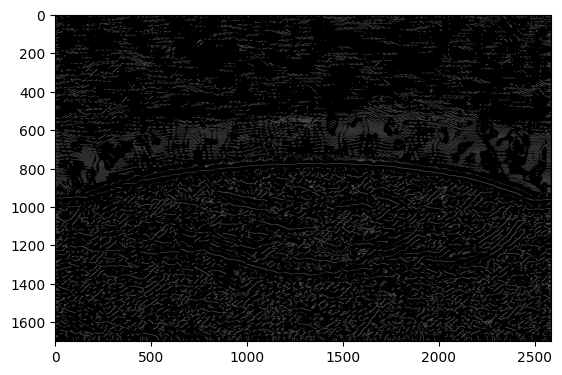

In [95]:
plt.imshow(thinned_output.dot(1/thinned_output.max()) >.01, cmap = plt.get_cmap('gray'))
plt.show()

In [96]:
low = 0.1
high = 0.35
lowt = (thinned_output > low).astype(int)
hight = (thinned_output > high).astype(int)
hyst = flt.apply_hysteresis_threshold(thinned_output, low, high)

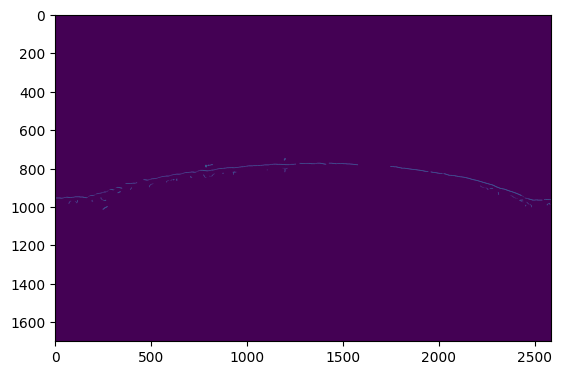

In [97]:
plt.imshow(hyst)

# Investigating peak selection based on statistical significance of the peaks

The peaks height in each line profile has a single peak around the baseline. We expect the ones that are at the edge of the distribution will contain the contour points of the ROI.

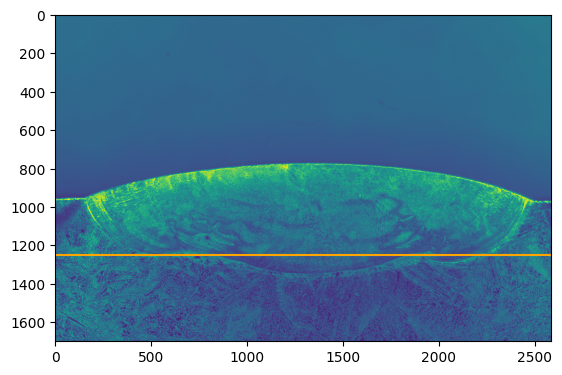

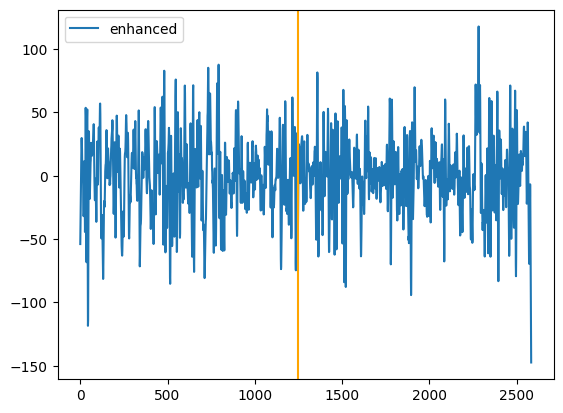

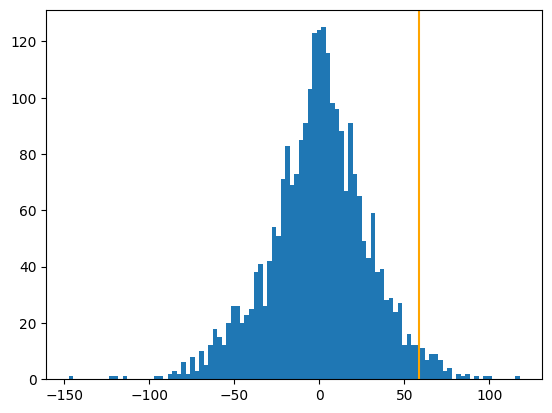

In [72]:
yline = 1250
plt.imshow(gray)
plt.axhline(yline,color='orange')
plt.show()

sav_2d_gray = savgol_filter(gray[yline], 51, 3, deriv=2) 
sav_2d_abs_gray = abs(sav_2d_gray)

sav_2d_nni = savgol_filter(img_as_float(new_new_image)[yline], 11, 3, deriv=2) 
# sav_2d_abs_nni = (sav_2d_nni)

# plt.plot(sav_2d_abs_gray.dot(1/sav_2d_abs_gray.max()), label='original')
plt.plot(sav_2d_nni, label='enhanced')
plt.legend()
plt.axvline(1250, color='orange')
plt.show()
plt.hist(sav_2d_nni, bins=100)
plt.axvline(2*sav_2d_nni.std(), color='orange')
plt.show()

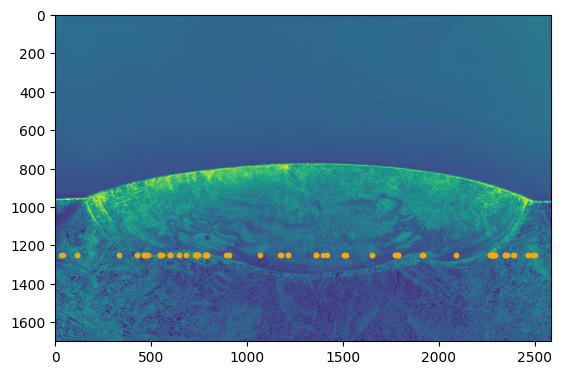

In [73]:
plt.imshow(gray)
selected = np.where(sav_2d_nni > 50)
plt.scatter(selected, np.full_like(selected, yline),color='orange', marker ='.')
plt.show()


In [74]:
x_0, y_0 = [], []
for yline in range(900,1400):
    sav_2d_nni = savgol_filter(img_as_float(new_new_image)[yline], 21, 3, deriv=0) 
    thresh = 3*sav_2d_nni.std()
    selected = np.where(sav_2d_nni > thresh)
    x_0.append(np.array(selected))
    y_0.append(np.array(np.full_like(selected, yline)))
    
x_2, y_2 = [], []
for yline in range(900,1400):
    sav_2d_nni = savgol_filter(img_as_float(new_new_image)[yline], 21, 3, deriv=2) 
    thresh = 3*sav_2d_nni.std()
    selected = np.where(sav_2d_nni > thresh)
    x_2.append(np.array(selected))
    y_2.append(np.array(np.full_like(selected, yline)))


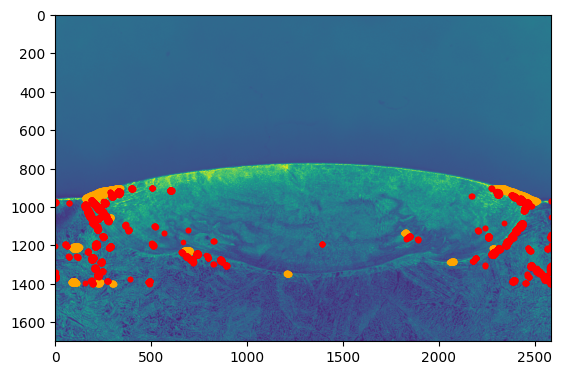

In [75]:
plt.imshow(gray)
plt.scatter(np.concatenate(x_0, axis=1).flatten(), np.concatenate(y_0, axis=1).flatten(),color='orange', marker ='.')
plt.scatter(np.concatenate(x_2, axis=1).flatten(), np.concatenate(y_2, axis=1).flatten(),color='red', marker ='.')

plt.show()

Testing on the original image is not very successful.

## Tests of statistical selection of peaks from the 2nd derivative image

In [76]:
x_0, y_0 = [], []
for yline in range(700,1400):
    sav_2d = savgol_filter(img_as_float(img_2nd_diff)[yline], 101, 3, deriv=0) 
    thresh = 3*sav_2d.std()
    selected = np.where(sav_2d > thresh)
    x_0.append(np.array(selected))
    y_0.append(np.array(np.full_like(selected, yline)))

x_0, y_0  = np.concatenate(x_0, axis=1).flatten(), np.concatenate(y_0, axis=1).flatten()
    


In [78]:
x_0x, y_0x = [], []
for xline in range(img_2nd_diff.shape[1]):
    sav_0d = savgol_filter(img_as_float(img_2nd_diff)[:,xline], 51, 3, deriv=0) 
    thresh = 2*sav_0d.std()
    selected = np.where(sav_0d > thresh)
    y_0x.append(np.array(selected))
    x_0x.append(np.array(np.full_like(selected, xline)))

x_0x, y_0x = np.concatenate(x_0x, axis=1).flatten(), np.concatenate(y_0x, axis=1).flatten()


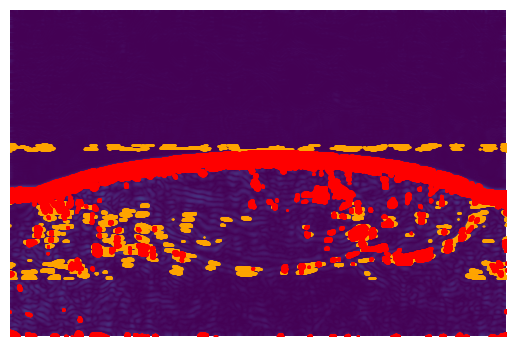

In [79]:
fig = plt.figure()
plt.imshow(img_2nd_diff)

plt.scatter(x_0, y_0,color='orange', marker ='.', s=1)
plt.scatter(x_0x, y_0x,color='red', marker ='.', s=1)
plt.axis('off')
plt.show()

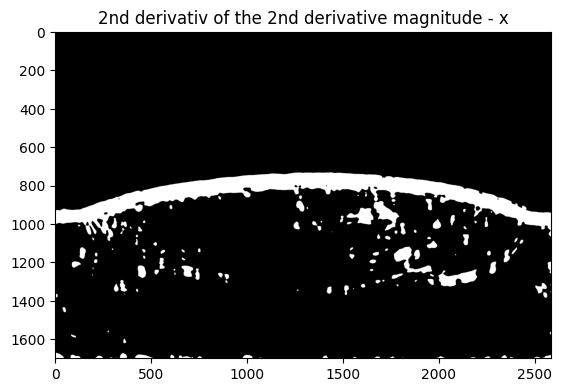

In [80]:
peaksx = np.full_like(img_2nd_diff, 0)
for i in range(len(x_0x)):
    peaksx[y_0x[i], x_0x[i]] = 1

plt.imshow(peaksx, cmap=plt.cm.gray)
plt.title('2nd derivativ of the 2nd derivative magnitude - x')
plt.show()


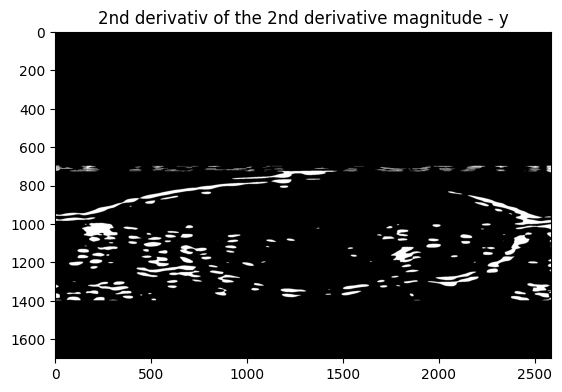

In [81]:
peaksy = np.full_like(img_2nd_diff, 0)
for i in range(len(x_0)):
    peaksy[y_0[i], x_0[i]] = 1

plt.imshow(peaksy, cmap=plt.cm.gray)
plt.title('2nd derivativ of the 2nd derivative magnitude - y')
plt.show()

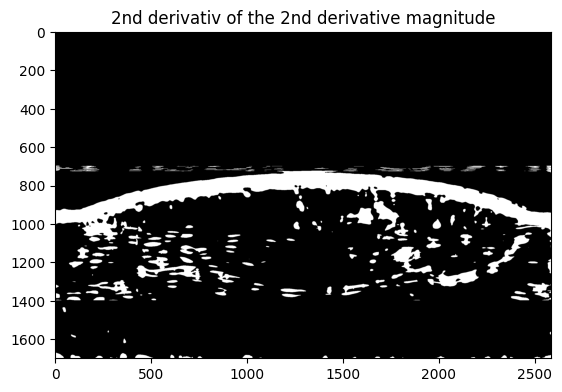

In [82]:
plt.imshow((peaksy + peaksx)>0, cmap=plt.cm.gray)
plt.title('2nd derivativ of the 2nd derivative magnitude')
plt.show()

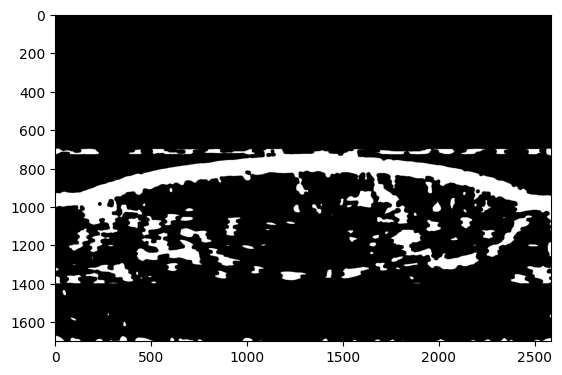

In [83]:
c = morphology.closing((peaksy + peaksx)>0, footprint=morphology.disk(10))
plt.imshow(c, cmap=plt.cm.gray)
plt.show()

In [84]:
x_2, y_2 = [], []
for yline in range(700,1400):
    sav_2d = savgol_filter(img_as_float(img_2nd_diff)[yline], 101, 3, deriv=2) 
    thresh = 3*sav_2d.std()
    selected = np.where(sav_2d > thresh)
    x_2.append(np.array(selected))
    y_2.append(np.array(np.full_like(selected, yline)))

x_2, y_2  = np.concatenate(x_2, axis=1).flatten(), np.concatenate(y_2, axis=1).flatten()
    


In [85]:
x_2x, y_2x = [], []
for xline in range(img_2nd_diff.shape[1]):
    sav_2d = savgol_filter(img_as_float(img_2nd_diff)[:,xline], 51, 3, deriv=2) 
    thresh = 2*sav_2d.std()
    selected = np.where(sav_2d > thresh)
    y_2x.append(np.array(selected))
    x_2x.append(np.array(np.full_like(selected, xline)))

x_2x, y_2x = np.concatenate(x_2x, axis=1).flatten(), np.concatenate(y_2x, axis=1).flatten()


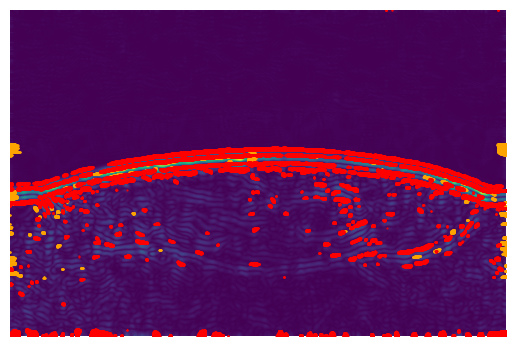

In [86]:
fig = plt.figure()
plt.imshow(img_2nd_diff)

plt.scatter(x_2, y_2,color='orange', marker ='.', s=1)
plt.scatter(x_2x, y_2x,color='red', marker ='.', s=1)
plt.axis('off')
plt.show()

In [87]:
x_1, y_1 = [], []
for yline in range(700,1400):
    sav = savgol_filter(img_as_float(img_2nd_diff)[yline], 101, 3, deriv=1) 
    thresh = 3*sav.std()
    selected = np.where(sav > thresh)
    x_1.append(np.array(selected))
    y_1.append(np.array(np.full_like(selected, yline)))

x_1, y_1  = np.concatenate(x_1, axis=1).flatten(), np.concatenate(y_1, axis=1).flatten()
    


In [88]:
x_1x, y_1x = [], []
for xline in range(img_2nd_diff.shape[1]):
    sav = savgol_filter(img_as_float(img_2nd_diff)[:,xline], 51, 3, deriv=1) 
    thresh = 2*sav.std()
    selected = np.where(sav > thresh)
    y_1x.append(np.array(selected))
    x_1x.append(np.array(np.full_like(selected, xline)))

x_1x, y_1x = np.concatenate(x_1x, axis=1).flatten(), np.concatenate(y_1x, axis=1).flatten()


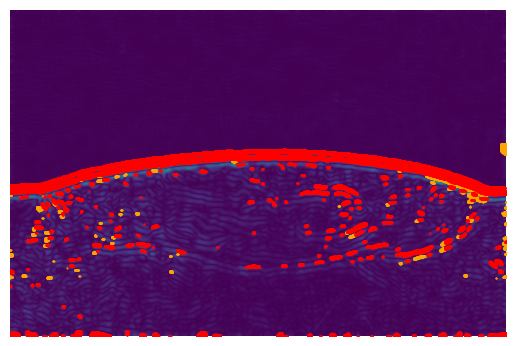

In [89]:
fig = plt.figure()
plt.imshow(img_2nd_diff)

plt.scatter(x_1, y_1,color='orange', marker ='.', s=1)
plt.scatter(x_1x, y_1x,color='red', marker ='.', s=1)
plt.axis('off')
plt.show()

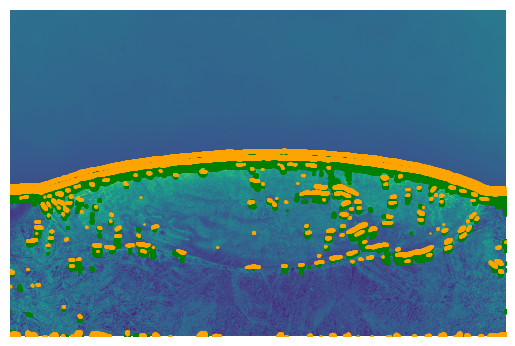

In [93]:
fig = plt.figure()
plt.imshow(gray)

plt.scatter(x_0x, y_0x,color='green', marker ='.', s=1)
plt.scatter(x_1x, y_1x,color='orange', marker ='.', s=1)
# plt.scatter(x_2x, y_2x,color='red', marker ='.', s=1)


plt.axis('off')
plt.show()

Things to test:
- Thresholding 

# Testing the effect of Hue channel

(-0.5, 2583.5, 1699.5, -0.5)

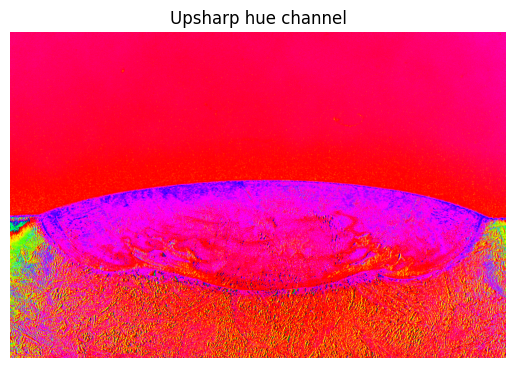

In [163]:
img = rgb2hsv(img)
amount = 5
radius = 2
upsharp_img_h = flt.unsharp_mask(img, radius=radius, amount=amount, channel_axis=0)

plt.imshow(upsharp_img_h)
plt.title('Upsharp hue channel')
plt.axis('off')

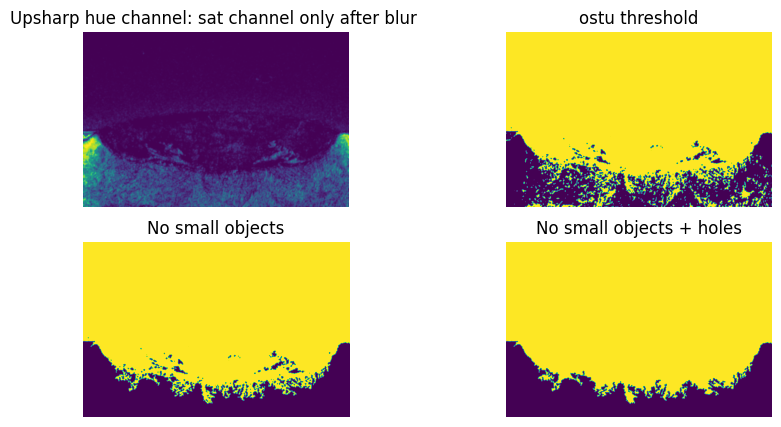

In [177]:
gauss_s = flt.gaussian(upsharp_img_h[:,:,1], sigma=5)
mask = gauss_s < flt.threshold_otsu((gauss_s))
mask_no_small_objects = morphology.remove_small_objects(mask, 30000)
mask_no_small_objects_holes = morphology.remove_small_holes(mask_no_small_objects, 30000)


fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(gauss_s)
ax[0].set_title('Upsharp hue channel: sat channel only after blur ')
ax[0].set_axis_off()

ax[1].imshow(mask)
ax[1].set_title('ostu threshold')
ax[1].set_axis_off()

ax[2].imshow(mask_no_small_objects)
ax[2].set_title('No small objects')
ax[2].set_axis_off()

ax[3].imshow(mask_no_small_objects_holes)
ax[3].set_title('No small objects + holes')
ax[3].set_axis_off()

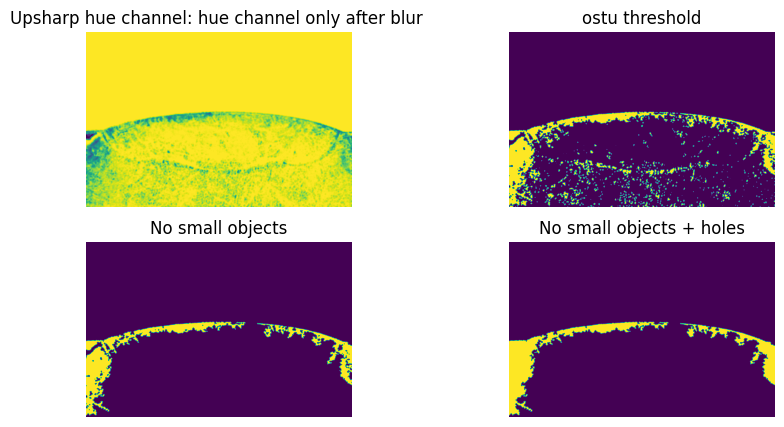

In [ ]:
gauss_h = flt.gaussian(upsharp_img_h[:,:,0], sigma=5)
h_mask = gauss_h < flt.threshold_otsu((gauss_h))
h_mask_no_small_objects = morphology.remove_small_objects(h_mask, 30000)
h_mask_no_small_objects_holes = morphology.remove_small_holes(h_mask_no_small_objects, 30000)


fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(gauss_h)
ax[0].set_title('Upsharp hue channel: hue channel only after blur ')
ax[0].set_axis_off()

ax[1].imshow(h_mask)
ax[1].set_title('ostu threshold')
ax[1].set_axis_off()

ax[2].imshow(h_mask_no_small_objects)
ax[2].set_title('No small objects')
ax[2].set_axis_off()

ax[3].imshow(h_mask_no_small_objects_holes)
ax[3].set_title('No small objects + holes')
ax[3].set_axis_off()

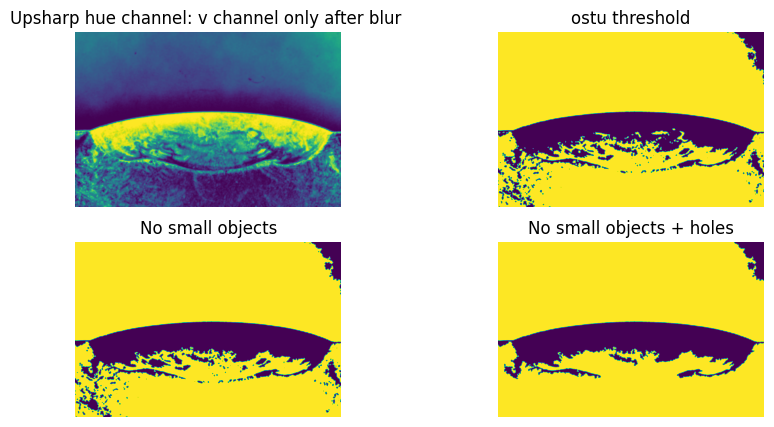

In [181]:
gauss_v = flt.gaussian(upsharp_img_h[:,:,2], sigma=5)
v_mask = gauss_v < flt.threshold_otsu((gauss_v))
v_mask_no_small_objects = morphology.remove_small_objects(v_mask, 30000)
v_mask_no_small_objects_holes = morphology.remove_small_holes(v_mask_no_small_objects, 30000)


fig, axes = plt.subplots(ncols=2, nrows = 2, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(gauss_v)
ax[0].set_title('Upsharp hue channel: v channel only after blur ')
ax[0].set_axis_off()

ax[1].imshow(v_mask)
ax[1].set_title('ostu threshold')
ax[1].set_axis_off()

ax[2].imshow(v_mask_no_small_objects)
ax[2].set_title('No small objects')
ax[2].set_axis_off()

ax[3].imshow(v_mask_no_small_objects_holes)
ax[3].set_title('No small objects + holes')
ax[3].set_axis_off()

combining



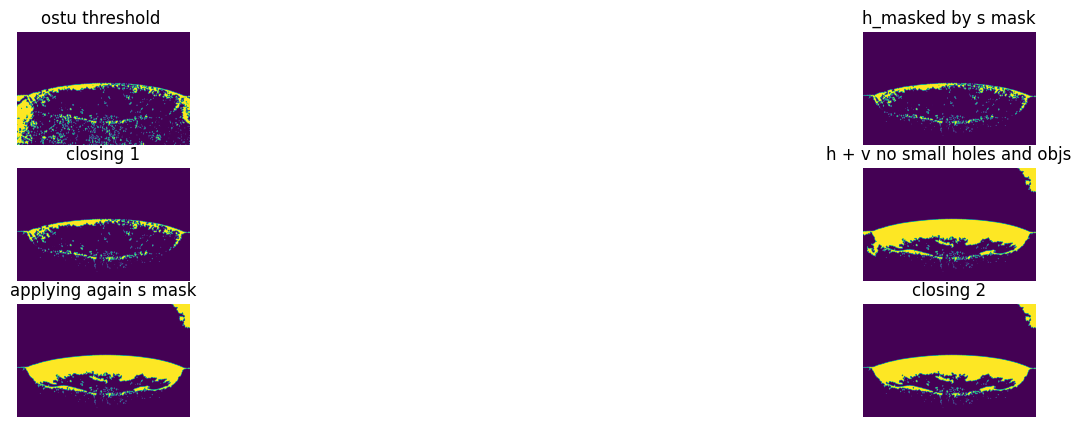

In [198]:

h_mask = gauss_h < flt.threshold_otsu((gauss_h))
masked_h = np.multiply(h_mask, mask_no_small_objects_holes)
closed = morphology.closing(masked_h, morphology.disk(6))

fig, axes = plt.subplots(ncols=2, nrows = 3, figsize=(20, 5))
ax = axes.ravel()

ax[0].imshow(h_mask)
ax[0].set_title('ostu threshold ')
ax[0].set_axis_off()

ax[1].imshow(masked_h)
ax[1].set_title('h_masked by s mask')
ax[1].set_axis_off()

ax[2].imshow(closed)
ax[2].set_title('closing 1')
ax[2].set_axis_off()

ax[3].imshow(masked_h + (v_mask_no_small_objects_holes<1))
ax[3].set_title('h + v no small holes and objs')
ax[3].set_axis_off()

ax[4].imshow(np.multiply(masked_h + (v_mask_no_small_objects_holes<1), mask_no_small_objects_holes))
ax[4].set_title('applying again s mask')
ax[4].set_axis_off()

ax[5].imshow(morphology.closing(\
                        np.multiply(masked_h + (v_mask_no_small_objects_holes<1), 
                                    mask_no_small_objects_holes), morphology.disk(7)))
ax[5].set_title('closing 2')
ax[5].set_axis_off()

Testing on laplace enhanced image